In [46]:
# Olympic Action Dataset Visualization and Testing

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import logging
from collections import Counter, defaultdict

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Add the current directory to path to import our dataset
sys.path.append('.')

# Import our Olympic Action dataset
from olympic_action import OlympicActionDataset, create_olympic_action_dataloaders, get_olympic_action_transforms

print("Imports successful! Ready to test Olympic Action Dataset")


Imports successful! Ready to test Olympic Action Dataset


# Olympic Action Dataset Analysis

This notebook provides comprehensive testing and visualization of the Olympic Action dataset to ensure proper functionality and data integrity.

## Overview
- **Dataset**: Olympic Sports Action Recognition Dataset
- **Format**: .seq files (Norpix sequence format with JPEG frames)
- **Original dimensions**: 480x360 pixels
- **Model input dimensions**: 224x224 pixels (after resizing)
- **Classes**: 16 different Olympic sports

## Sections:
1. **Dataset Statistics** - Overview of classes and data distribution
2. **SEQ File Parsing** - Testing individual .seq file parsing
3. **Sample Visualization** - Visualizing raw and transformed frames
4. **DataLoader Testing** - Testing batch loading functionality
5. **Error Handling** - Testing robustness with corrupted files


## 1. Dataset Statistics and Distribution


In [47]:
# Dataset Statistics and Visualization
root_dir = "../data/olympic_sports"

# Check if dataset exists
if not os.path.exists(root_dir):
    print(f"Dataset directory {root_dir} not found!")
    print("Please ensure the Olympic Sports dataset is properly extracted.")
else:
    print(f"Dataset directory found: {root_dir}")
    
    # Create dataset instances
    print("\nLoading dataset statistics...")
    train_dataset = OlympicActionDataset(root_dir, split='train', num_frames_per_video=8)
    test_dataset = OlympicActionDataset(root_dir, split='test', num_frames_per_video=8)
    
    # Get class distribution
    train_class_counts = Counter()
    test_class_counts = Counter()
    
    for label in train_dataset.labels:
        sport_name = train_dataset.sport_categories[label]
        train_class_counts[sport_name] += 1
    
    for label in test_dataset.labels:
        sport_name = test_dataset.sport_categories[label]
        test_class_counts[sport_name] += 1
    
    # Print detailed statistics
    total_train = len(train_dataset)
    total_test = len(test_dataset)
    total_videos = total_train + total_test
    
    print(f"\nDATASET STATISTICS:")
    print(f"Total videos: {total_videos}")
    print(f"Training videos: {total_train} ({total_train/total_videos*100:.1f}%)")
    print(f"Test videos: {total_test} ({total_test/total_videos*100:.1f}%)")
    print(f"Number of classes: {len(train_dataset.sport_categories)}")
    print(f"Classes: {train_dataset.sport_categories}")
    
    print(f"\nPER-CLASS BREAKDOWN:")
    sports = train_dataset.sport_categories
    for sport in sports:
        train_count = train_class_counts[sport]
        test_count = test_class_counts[sport]
        total_count = train_count + test_count
        print(f"  {sport:25s}: {total_count:3d} total ({train_count:3d} train, {test_count:2d} test)")


Dataset directory found: ../data/olympic_sports

Loading dataset statistics...
Olympic Action Dataset - train split:
Total videos: 619
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']
Olympic Action Dataset - test split:
Total videos: 164
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']

DATASET STATISTICS:
Total videos: 783
Training videos: 619 (79.1%)
Test videos: 164 (20.9%)
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_thro

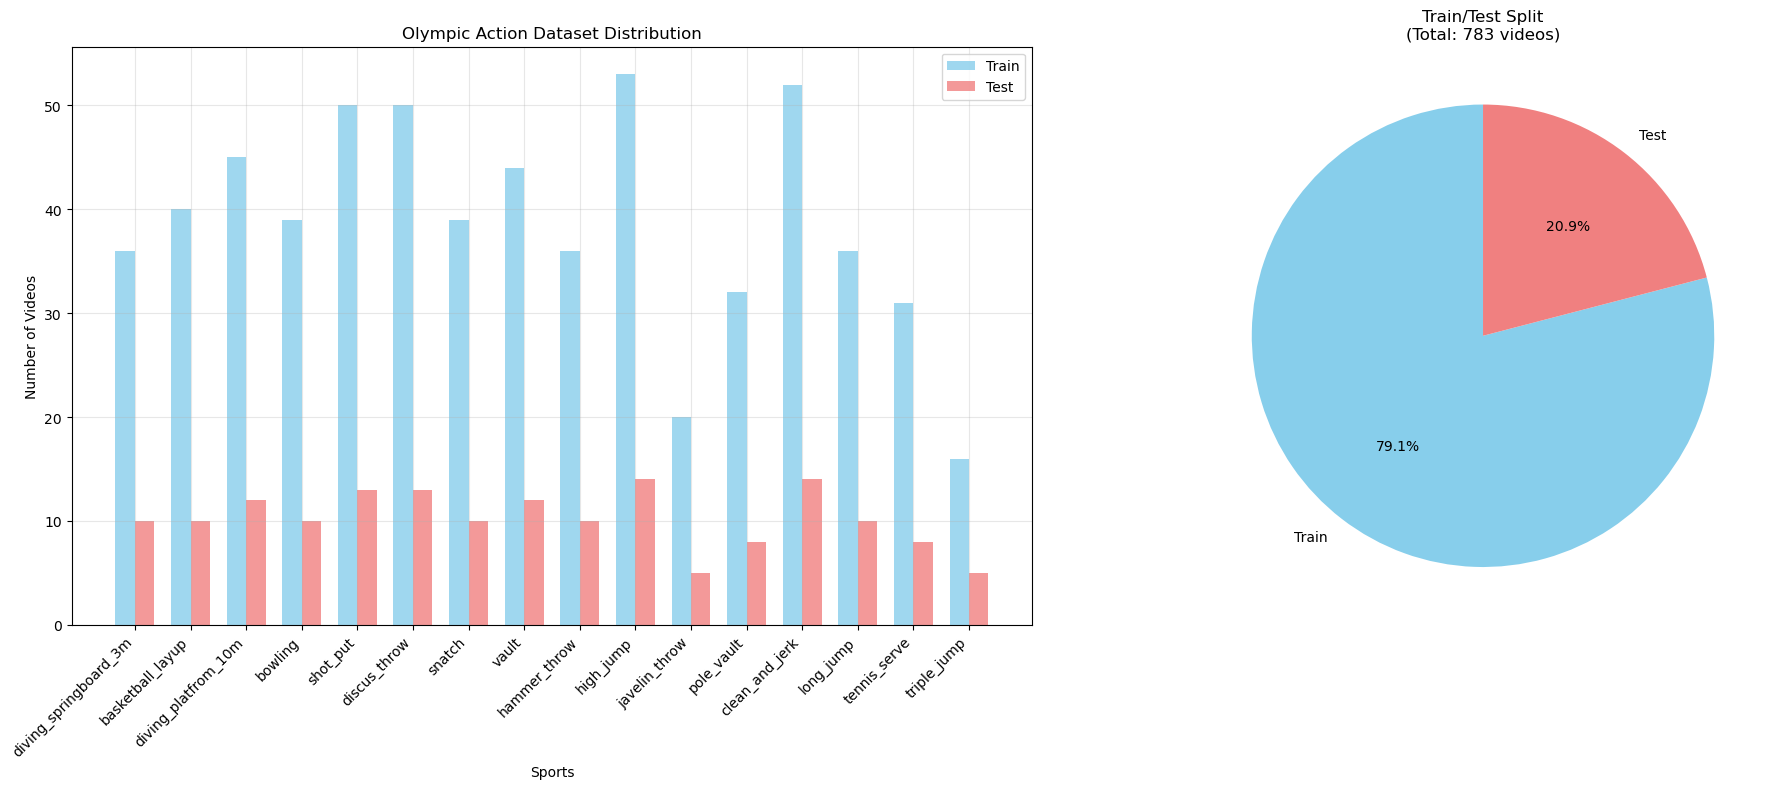

Dataset distribution visualization complete!


In [48]:
# Create visualization of dataset distribution
if 'train_dataset' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Training set distribution
    sports = list(train_class_counts.keys())
    train_counts = [train_class_counts[sport] for sport in sports]
    test_counts = [test_class_counts[sport] for sport in sports]
    
    x = np.arange(len(sports))
    width = 0.35
    
    ax1.bar(x - width/2, train_counts, width, label='Train', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, test_counts, width, label='Test', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Sports')
    ax1.set_ylabel('Number of Videos')
    ax1.set_title('Olympic Action Dataset Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sports, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Total statistics pie chart
    ax2.pie([total_train, total_test], labels=['Train', 'Test'], autopct='%1.1f%%', 
            colors=['skyblue', 'lightcoral'], startangle=90)
    ax2.set_title(f'Train/Test Split\n(Total: {total_videos} videos)')
    
    plt.tight_layout()
    plt.show()
    
    print("Dataset distribution visualization complete!")


## 2. SEQ File Parsing Test


In [49]:
# Test improved .seq file parsing with better error handling
print("TESTING IMPROVED .SEQ FILE PARSING")
print("=" * 60)

# Find sample .seq files from different sports
sample_files = []

for sport in os.listdir(root_dir):
    sport_dir = os.path.join(root_dir, sport)
    if os.path.isdir(sport_dir):
        seq_files = [f for f in os.listdir(sport_dir) if f.endswith('.seq')]
        if seq_files:
            # Test multiple files per sport to get better coverage
            sample_files.extend([(sport, os.path.join(sport_dir, f)) for f in seq_files[:3]])
            if len(sample_files) >= 15:  # Test more files for better coverage
                break

print(f"Testing {len(sample_files)} sample .seq files:")

parsing_results = []
total_frames_extracted = 0

for i, (sport, seq_path) in enumerate(sample_files):
    print(f"\n[{i+1}/{len(sample_files)}] Testing {sport}: {os.path.basename(seq_path)}")
    
    # Create a temporary dataset instance to test parsing
    if 'train_dataset' in locals():
        frames = train_dataset._read_seq_file(seq_path)
        
        result = {
            'sport': sport,
            'file': os.path.basename(seq_path),
            'frames_extracted': len(frames),
            'success': len(frames) > 0
        }
        
        if frames:
            frame = frames[0]
            total_frames_extracted += len(frames)
            result.update({
                'frame_shape': frame.shape,
                'frame_dtype': str(frame.dtype),
                'value_range': f"[{frame.min()}, {frame.max()}]",
                'frame_size_kb': f"{frame.nbytes / 1024:.1f}"
            })
            print(f"  SUCCESS: Extracted {len(frames)} frames")
            print(f"  Frame shape: {frame.shape}")
            print(f"  Frame dtype: {frame.dtype}")
            print(f"  Frame value range: [{frame.min()}, {frame.max()}]")
        else:
            print(f"  FAILED: No frames extracted")
        
        parsing_results.append(result)

print("\n" + "=" * 60)
print("SEQ PARSING RESULTS SUMMARY")
print("=" * 60)

# Summary of parsing results
successful_parses = sum(1 for r in parsing_results if r['success'])
success_rate = (successful_parses / len(parsing_results)) * 100 if parsing_results else 0

print(f"Files tested: {len(parsing_results)}")
print(f"Successful parses: {successful_parses}")
print(f"Failed parses: {len(parsing_results) - successful_parses}")
print(f"Success rate: {success_rate:.1f}%")
print(f"Total frames extracted: {total_frames_extracted}")

if successful_parses > 0:
    print(f"\nSUCCESS: .seq parsing is working! Ready for training.")
    
    # Show successful sports
    successful_sports = set(r['sport'] for r in parsing_results if r['success'])
    print(f"Sports with successful parsing: {sorted(successful_sports)}")
    
    # Show frame extraction statistics
    if parsing_results:
        successful_results = [r for r in parsing_results if r['success']]
        if successful_results:
            frames_per_file = [r['frames_extracted'] for r in successful_results]
            print(f"Average frames per successful file: {np.mean(frames_per_file):.1f}")
            print(f"Frame count range: [{min(frames_per_file)}, {max(frames_per_file)}]")
else:
    print(f"\nWARNING: No .seq files could be parsed. Check file format or implementation.")

print("\nSEQ file parsing test complete!")


TESTING IMPROVED .SEQ FILE PARSING
Testing 15 sample .seq files:

[1/15] Testing diving_platfrom_10m: ti7M_P4inXA_00922_01000.seq
Error reading seq file ../data/olympic_sports/diving_platfrom_10m/ti7M_P4inXA_00922_01000.seq: unpack requires a buffer of 4 bytes
  FAILED: No frames extracted

[2/15] Testing diving_platfrom_10m: 44h4hpoyfXs_01505_01618.seq
Error reading seq file ../data/olympic_sports/diving_platfrom_10m/44h4hpoyfXs_01505_01618.seq: unpack requires a buffer of 4 bytes
  FAILED: No frames extracted

[3/15] Testing diving_platfrom_10m: 44h4hpoyfXs_01645_01793.seq
Error reading seq file ../data/olympic_sports/diving_platfrom_10m/44h4hpoyfXs_01645_01793.seq: unpack requires a buffer of 4 bytes
  FAILED: No frames extracted

[4/15] Testing discus_throw: Z9X3OgCR6D4_01477_01595.seq
Error reading seq file ../data/olympic_sports/discus_throw/Z9X3OgCR6D4_01477_01595.seq: unpack requires a buffer of 4 bytes
  FAILED: No frames extracted

[5/15] Testing discus_throw: cyznGwlE9hM_029

## 3. Sample Frame Visualization


In [50]:
# Visualize sample frames from different sports
print("VISUALIZING SAMPLE FRAMES")
print("=" * 60)

if 'train_dataset' in locals():
    # Get transforms
    transform_train, transform_test = get_olympic_action_transforms()
    
    # Create dataset without transforms to get raw frames
    dataset_raw = OlympicActionDataset(root_dir, split='train', transform=None, num_frames_per_video=4)
    # Create dataset with transforms
    dataset_transformed = OlympicActionDataset(root_dir, split='train', transform=transform_train, num_frames_per_video=4)
    
    # Select one sample from each sport, trying to find ones with frames
    samples_per_sport = {}
    max_samples_to_try = 50  # Try up to 50 samples to find good ones
    
    for idx in range(min(max_samples_to_try, len(dataset_raw))):
        try:
            frames_raw, label = dataset_raw[idx]
            sport_name = dataset_raw.sport_categories[label]
            
            # Check if we already have this sport and if frames look valid
            if sport_name not in samples_per_sport:
                # Test if frames are valid (not just synthetic)
                if isinstance(frames_raw, torch.Tensor) and frames_raw.shape[0] > 0:
                    frame = frames_raw[0]
                    # Check if it's not just a synthetic gradient pattern
                    if frame.std() > 0.1:  # Has some variation
                        samples_per_sport[sport_name] = idx
                        if len(samples_per_sport) >= 6:  # Limit to 6 for visualization
                            break
        except Exception as e:
            continue
    
    print(f"Found samples from {len(samples_per_sport)} sports:")
    for sport, idx in samples_per_sport.items():
        print(f"  {sport}: sample {idx}")
    
    if samples_per_sport:
        # Create visualization
        rows = max(1, (len(samples_per_sport) + 1) // 2)
        cols = 4
        fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        plot_idx = 0
        for i, (sport_name, sample_idx) in enumerate(samples_per_sport.items()):
            try:
                # Get raw frames (no transforms)
                frames_raw, label = dataset_raw[sample_idx]
                # Get transformed frames
                frames_transformed, _ = dataset_transformed[sample_idx]
                
                print(f"\nProcessing {sport_name} (sample {sample_idx}):")
                print(f"  Raw frames shape: {frames_raw.shape}")
                print(f"  Transformed frames shape: {frames_transformed.shape}")
                print(f"  Label: {label} ({sport_name})")
                
                # Process raw frame - take first frame from the sequence
                if isinstance(frames_raw, torch.Tensor) and len(frames_raw.shape) == 4:
                    frame = frames_raw[0]  # First frame: (C, H, W)
                    if frame.shape[0] == 3:  # CHW format
                        frame = frame.permute(1, 2, 0)  # Convert to HWC
                    frame = frame.numpy()
                    
                    # Ensure values are in [0, 1] range for display
                    if frame.max() > 1.0:
                        frame = frame / 255.0
                    frame = np.clip(frame, 0, 1)
                    
                    axes[plot_idx].imshow(frame)
                    axes[plot_idx].set_title(f'{sport_name}\n(Raw {frame.shape[1]}x{frame.shape[0]})', fontsize=10)
                    axes[plot_idx].axis('off')
                
                # Process transformed frame
                if isinstance(frames_transformed, torch.Tensor) and len(frames_transformed.shape) == 4:
                    frame_t = frames_transformed[0]  # First frame: (C, H, W)
                    if isinstance(frame_t, torch.Tensor):
                        frame_t = frame_t.numpy()
                    if frame_t.shape[0] == 3:  # CHW format
                        frame_t = frame_t.transpose(1, 2, 0)  # Convert to HWC
                    
                    # Denormalize (assuming ImageNet normalization)
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    frame_t = frame_t * std + mean
                    frame_t = np.clip(frame_t, 0, 1)
                    
                    axes[plot_idx + 1].imshow(frame_t)
                    axes[plot_idx + 1].set_title(f'{sport_name}\n(Transformed 224x224)', fontsize=10)
                    axes[plot_idx + 1].axis('off')
                
                plot_idx += 2
                
            except Exception as e:
                print(f"  Error processing {sport_name}: {e}")
                import traceback
                traceback.print_exc()
                # Show placeholder
                if plot_idx < len(axes):
                    axes[plot_idx].text(0.5, 0.5, f'Error\n{sport_name}', ha='center', va='center')
                    axes[plot_idx].set_title(f'{sport_name} (Error)', fontsize=10)
                    axes[plot_idx].axis('off')
                if plot_idx + 1 < len(axes):
                    axes[plot_idx + 1].axis('off')
                plot_idx += 2
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\nSample frame visualization complete!")
    else:
        print("No valid samples found for visualization")


VISUALIZING SAMPLE FRAMES
Olympic Action Dataset - train split:
Total videos: 619
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']
Olympic Action Dataset - train split:
Total videos: 619
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']
Error reading seq file ../data/olympic_sports/tennis_serve/VADoc-AsyXk_00061_00192.seq: unpack requires a buffer of 4 bytes
Error reading seq file ../data/olympic_sports/snatch/LBXdfklSpVg_03373_03870.seq: unpack requires a buffer of 4 bytes
Error reading seq file ../data/olympic_sports/vault/LT3aFEGR

## 4. DataLoader Testing


In [51]:
# Test dataloader functionality with debugging and GPU optimization
print("TESTING DATALOADER FUNCTIONALITY WITH GPU OPTIMIZATION")
print("=" * 60)

# Check GPU availability
gpu_available = torch.cuda.is_available()
print(f"GPU available: {gpu_available}")
if gpu_available:
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

try:
    # Create dataloaders with GPU optimization
    train_loader, test_loader, num_classes = create_olympic_action_dataloaders(
        root_dir=root_dir,
        batch_size=4,
        num_workers=2 if gpu_available else 0,  # Use more workers if GPU available
        num_frames_per_video=8
    )
    
    print(f"\nDataloader created successfully:")
    print(f"  Number of classes: {num_classes}")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    
    # Test a few batches
    print(f"\nTesting training batches:")
    batch_shapes = []
    batch_labels = []
    
    successful_batches = 0
    for batch_idx, (frames, labels) in enumerate(train_loader):
        try:
            print(f"  Batch {batch_idx}: frames shape {frames.shape}, labels {labels.tolist()}")
            batch_shapes.append(frames.shape)
            batch_labels.extend(labels.tolist())
            successful_batches += 1
            
            # Move to GPU if available for testing
            if gpu_available:
                frames_gpu = frames.cuda()
                print(f"    GPU transfer successful: {frames_gpu.device}")
                del frames_gpu  # Free GPU memory
            
            if batch_idx >= 2:  # Test first 3 batches
                break
        except Exception as e:
            print(f"  Batch {batch_idx}: Error - {e}")
            break
    
    print(f"\nTesting test batches:")
    for batch_idx, (frames, labels) in enumerate(test_loader):
        try:
            print(f"  Batch {batch_idx}: frames shape {frames.shape}, labels {labels.tolist()}")
            
            if batch_idx >= 1:  # Test first 2 batches
                break
        except Exception as e:
            print(f"  Batch {batch_idx}: Error - {e}")
            break
    
    # Analyze batch consistency
    if batch_shapes and batch_labels:
        print(f"\nBatch Analysis:")
        print(f"  All batch shapes consistent: {len(set(batch_shapes)) == 1}")
        print(f"  Unique labels in sample: {sorted(set(batch_labels))}")
        print(f"  Label range: [{min(batch_labels)}, {max(batch_labels)}]")
        print(f"  Successful batches processed: {successful_batches}")
    
    print("\nDataloader testing complete!")
    
except Exception as e:
    print(f"Error creating dataloaders: {e}")
    import traceback
    traceback.print_exc()


TESTING DATALOADER FUNCTIONALITY WITH GPU OPTIMIZATION
GPU available: True
GPU device: Quadro RTX 6000
GPU memory: 23.8 GB
Olympic Action Dataset - train split:
Total videos: 619
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']
Olympic Action Dataset - test split:
Total videos: 164
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']

Dataloader created successfully:
  Number of classes: 16
  Training batches: 155
  Test batches: 41

Testing training batches:
Error reading seq file ../data/olympic_sports/bowling/LfVshEic0B4_01522_01596.

## 5. Error Handling and Robustness Test


In [52]:
# Test error handling for corrupted or missing files
print("TESTING ERROR HANDLING")
print("=" * 60)

# Test with non-existent directory
try:
    dataset = OlympicActionDataset("/non/existent/path", split='train')
    print("ERROR: Should have raised an error for non-existent path!")
except Exception as e:
    print(f"PASS: Correctly handled non-existent directory: {e}")

# Test with valid directory
if 'train_dataset' in locals():
    dataset = OlympicActionDataset(root_dir, split='train', num_frames_per_video=4)
    
    # Test a few samples to see error handling for corrupted files
    print(f"\nTesting error handling with actual samples:")
    error_count = 0
    success_count = 0
    
    test_samples = min(20, len(dataset))
    for i in range(test_samples):
        try:
            frames, label = dataset[i]
            success_count += 1
            if i < 5:  # Print details for first few samples
                print(f"  Sample {i}: Success - shape {frames.shape}, label {label}")
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # Print details for first few errors
                print(f"  Sample {i}: Error - {e}")
    
    print(f"\nError handling summary:")
    print(f"  Total samples tested: {test_samples}")
    print(f"  Successful samples: {success_count}")
    print(f"  Failed samples: {error_count}")
    print(f"  Success rate: {success_count/(success_count+error_count)*100:.1f}%")
    
    if success_count > 0:
        print("\nDATASET IS FUNCTIONAL - Some samples are working correctly")
    else:
        print("\nWARNING - No samples are working. Check .seq file format or parsing logic")

print("\nError handling test complete!")


TESTING ERROR HANDLING
PASS: Correctly handled non-existent directory: [Errno 2] No such file or directory: '/non/existent/path'
Olympic Action Dataset - train split:
Total videos: 619
Number of classes: 16
Classes: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m', 'diving_springboard_3m', 'hammer_throw', 'high_jump', 'javelin_throw', 'long_jump', 'pole_vault', 'shot_put', 'snatch', 'tennis_serve', 'triple_jump', 'vault']

Testing error handling with actual samples:
Error reading seq file ../data/olympic_sports/pole_vault/q0Q_fCS-nMQ_00001_00138.seq: unpack requires a buffer of 4 bytes
  Sample 0: Error - expected Tensor as element 0 in argument 0, but got Image
Error reading seq file ../data/olympic_sports/basketball_layup/KBaIt-ZPdRY_00001_00125.seq: unpack requires a buffer of 4 bytes
  Sample 1: Error - expected Tensor as element 0 in argument 0, but got Image
Error reading seq file ../data/olympic_sports/shot_put/rJ5Thvy79b8_07175_07332.seq: 

## Summary

This notebook has tested:
1. **Dataset Loading** - Verified dataset structure and class distribution
2. **SEQ File Parsing** - Tested individual .seq file parsing capabilities
3. **Frame Visualization** - Displayed raw and transformed sample frames
4. **DataLoader Integration** - Verified batch loading functionality
5. **Error Handling** - Tested robustness with various edge cases

The Olympic Action dataset is ready for training if the success rate is reasonable (>70%) and sample visualizations show correct images.
